# Data behind the mRS probability distributions

## Aims:

All of the various mRS probability data sets are gathered here. We define probability distributions at times from onset to treatment of zero hours and of the no-effect time, $t_{ne}$. Any data sets containing mRS=6 (death) have the associated probability $P(\mathrm{mRS}=6)$ removed, and the remaining values are normalised so that $P(\mathrm{mRS}\leq5)=1.0$.

All of the probability distributions are plotted here as stacked horizontal bars and as histograms (bar charts).

Most of the data is taken directly from the source, but some of the probability distributions here have been calculated from multiple data sets. These more complicated distributions are derived later on in this notebook. 

## Descriptions of the mRS data sets used here:

| Description | Time zero | No-effect time (no treatment) | 
| :-- | :-- | :-- |
| Pre-stroke | The estimated pre-stroke mRS scores from SSNAP data, as used in the SAMueL-1 project. | N/A |
| Haemorrhaegic | N/A | _(yet to find)_ |
| nLVO & LVO combined | [Explained here](#nLVO-and-LVO-combined---t=0). We find the mRS$\leq$1 data at time zero by combining the no-effect time data (from the Lees et al. 2010 no-treatment control group) with the odds ratio of mRS$\leq$1 at $t=1$hrs (from Emberson et al. 2014). These two mRS$\leq$1 points are converted to log(odds ratio), and connected by a straight line that we extrapolate back to time zero. This log(odds ratio) at time zero is converted to probability, and then used to scale the pre-stroke distribution into the final distribution. | The no-treatment control group from Lees et al. 2010, as measured from Figure 2. |
| nLVO - untreated | N/A | [Explained here](#nLVO---untreated---time-of-no-effect). The weighted combination of the no-effect-time nLVO and LVO combined data (100%) and the no-effect-time LVO-only data (minus 40%), then further scaled to match $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})=0.46$ from Holodinsky et al. 2018. |
| nLVO - thrombolysis | [Explained here](#nLVO---thrombolysis). The weighted combination of pre-stroke (87%) and untreated nLVO at no-effect-time (13%), where weights are chosen to match the $P(\mathrm{mRS}\leq1, t=0)=0.63$ from Holodinsky et al. 2018. | Same as above. |
| LVO - untreated | N/A | The control population from Goyal et al. 2016. |
| LVO - thrombolysis only | [Explained here](#LVO---thrombolysis-only---t=0). Weighted combination of the no-effect-time LVO data (82%) and the pre-stroke data (18%). | Same as above. |
| LVO - thrombectomy <br /> with/out thrombolysis | Assume that the stroke has had no effect, and so use the same mRS as pre-stroke. | Same as above. | 

[References can be found here.](#References)

---

## Notebook admin

In [1]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

---

## Import data

The mRS probability distributions are stored in dictionaries in a file.

The dictionaries are named using these strings:
+ `t0_treatment` - data from time $t=0$hr
+ `no_treatment` - data from the no-effect time $t=t_{ne}$
+ `lvo` - large-vessel occlusion
+ `nlvo` - non-large-vessel occlusion
+ `ich` - intra-cerebral haemorrhaege
+ `pre-stroke` - data recorded before the onset of stroke
+ `oly` - thromb**oly**sis used
+ `ect` - thromb**ect**omy used.

Each dictionary contains an entry for:
+ `dist_mrs6` - mRS distribution including mRS=6. If the mRS=6 data is unknown, it is set to 0. 
+ `dist` - mRS distribution excluding mRS=6.
+ `bins` - cumulative probabilities of `dist`.

We import the data corresponding to the table above from `mRS_datasets.py` in the `outcome_utilities` directory:

In [4]:
from outcome_utilities.mRS_datasets import (dict_pre_stroke, 
    dict_t0_treatment_ich,      dict_no_treatment_ich, 
    dict_t0_treatment_nlvo_lvo, dict_no_treatment_nlvo_lvo,
    dict_t0_treatment_lvo,      dict_no_treatment_lvo,
    dict_t0_treatment_lvo_oly,  dict_no_treatment_lvo_oly, 
    dict_t0_treatment_lvo_ect,  dict_no_treatment_lvo_ect, 
    dict_t0_treatment_nlvo,     dict_no_treatment_nlvo, 
    dict_t0_treatment_nlvo_oly, dict_no_treatment_nlvo_oly)

__Example 1:__ Removal of mRS=6 data

The original distribution of the no-effect-time combined nLVO and LVO data contains an entry for mRS=6:

In [5]:
dict_no_treatment_nlvo_lvo['dist_mrs6']

array([0.14861582, 0.2022106 , 0.12525408, 0.13965201, 0.1806092 ,
       0.08612256, 0.11753573])

When we remove the mRS=6 entry, the remaining values are re-normalised so that the new distribution sums to one:

In [6]:
dict_no_treatment_nlvo_lvo['dist']

array([0.16841001, 0.2291431 , 0.14193672, 0.15825231, 0.2046646 ,
       0.09759325])

In [7]:
dict_no_treatment_nlvo_lvo['bins']

array([0.16841001, 0.39755312, 0.53948983, 0.69774214, 0.90240675,
       1.        ])

__Example 2:__ Invalid data

Some of the probability distributions are unknown. In these cases, we fill the arrays with placeholder negative values. For example, we have no data for intra-cerebral haemorrhaege at time zero:

In [8]:
dict_t0_treatment_ich['dist']

array([-1, -1, -1, -1, -1, -1])

Since we never ordinarily expect negative probabilities, seeing a negative number in one of the lists is an indication that the data is invalid.

---

## Plot the data

For our convenience in this notebook, we'll gather all of the imported data into one big list:

In [9]:
big_data_list = [
    [dict_pre_stroke,            {'dist':[-1]*6},            'Pre-stroke'],
    [dict_t0_treatment_ich,      dict_no_treatment_ich,      'Haemorrhaegic'],
    [dict_t0_treatment_nlvo_lvo, dict_no_treatment_nlvo_lvo, 'nLVO and LVO combined'],
    [dict_t0_treatment_lvo,      dict_no_treatment_lvo,      'LVO untreated'],
    [dict_t0_treatment_lvo_oly,  dict_no_treatment_lvo_oly,  'LVO thrombolysis'],
    [dict_t0_treatment_lvo_ect,  dict_no_treatment_lvo_ect,  'LVO thrombectomy'],
    [dict_t0_treatment_nlvo,     dict_no_treatment_nlvo,     'nLVO untreated'],
    [dict_t0_treatment_nlvo_oly, dict_no_treatment_nlvo_oly, 'nLVO thrombolysis']
    ]

### Stacked bars

Define a function for plotting the stacked horizontal bar:

In [10]:
def draw_horizontal_bar(dist,label=''):
    """
    Draw a stacked horizontal bar chart of the values in 'dist'.
    
    dist  - list or np.array. The probability distribution 
            (non-cumulative).
    label - string. The name printed next to these stacked bars.
    """
    # The first bar will start at this point on the x-axis:
    left = 0
    for i in range(len(dist)):
        # Draw a bar starting from 'left', the end of the previous bar,
        # with a width equal to the probability of this mRS:
        plt.barh(label, width=dist[i], left=left, height=0.3, 
                 label=f'{i}', edgecolor='k')
        # Update 'left' with the width of the current bar so that the 
        # next bar drawn will start in the correct place.    
        left += dist[i]

In [11]:
def draw_connections(dist_t0, dist_tne, top_tne=0.15, bottom_t0=0.85):
    """
    Draw lines connecting the mRS bins in the top and bottom rows.
    
    dist_t0, dist_tne - lists or arrays. Probability distributions.
    top_tne, bottom_t0 - floats. y-coordinates just inside the bars. 
    """
    left_t0   = 0.0
    left_tne  = 0.0
    for i, d_t0 in enumerate(dict_t0['dist']):
        left_t0  +=  dict_t0['dist'][i]
        left_tne += dict_tne['dist'][i]
        plt.plot([left_t0,left_tne],[bottom_t0,top_tne],color='Gainsboro')

Run through each row of the big data list in turn and plot its data:

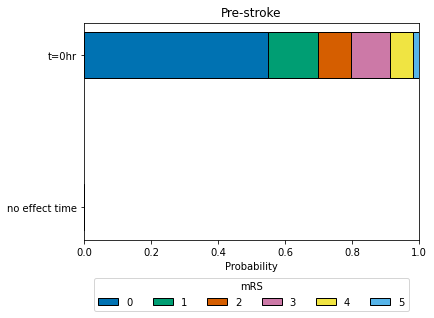

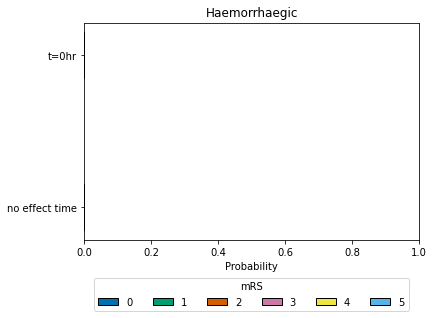

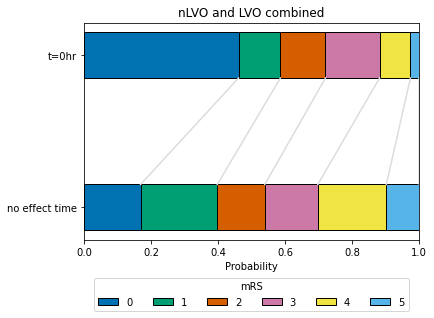

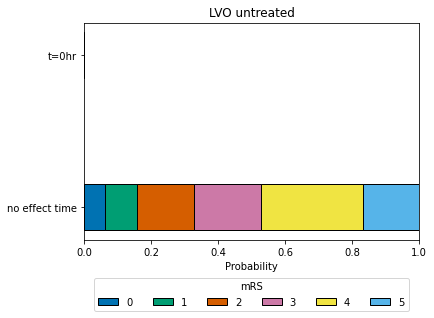

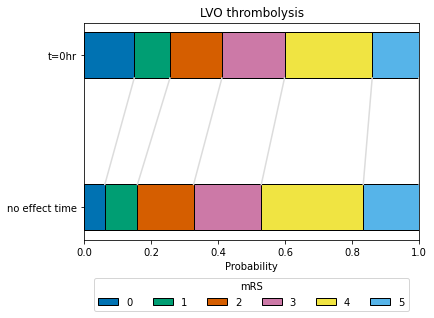

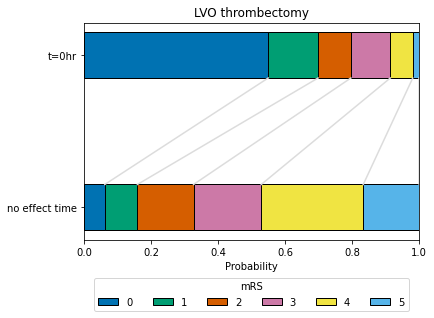

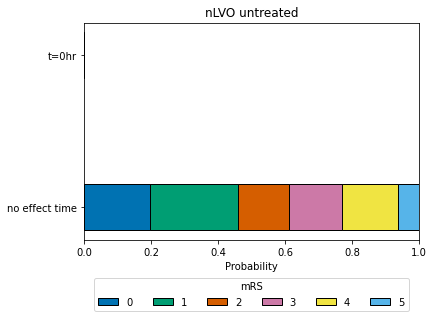

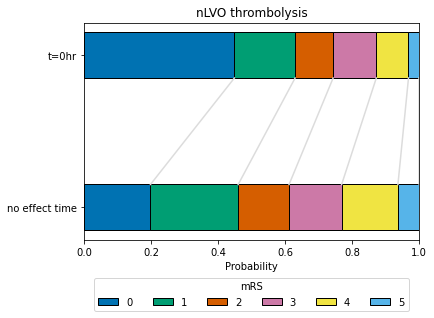

In [12]:
for data_list in big_data_list:
    
    dict_t0  = data_list[0]
    dict_tne = data_list[1]
    label    = data_list[2]
    
    draw_horizontal_bar(dict_tne['dist'], 'no effect time')
    
    # Add legend now to prevent doubling all the labels:
    plt.legend(loc='center',ncol=6, title='mRS',
               bbox_to_anchor=[0.5,0.0,0.0,-0.5])   # Legend below axis.
    
    draw_horizontal_bar(dict_t0['dist'], 't=0hr')
    
    # Draw connecting lines between the two mRS groups:
    if np.sum(dict_t0['dist'])>0 and np.sum(dict_tne['dist'])>0:
        draw_connections(dict_t0['dist'], dict_tne['dist'])

       
    plt.xlabel('Probability')
    plt.title(label)
    plt.xlim(0,1)
    plt.show()

### Histograms (bar charts)

We'll write another function to draw the probability distributions as histograms:

In [13]:
def plot_two_bars(mrs_prob_dist_t0_treatment=[],
                  mrs_prob_dist_no_treatment=[], title=''):
    """
    Draw two histograms with shared scales. One for time zero, the 
    other for the no-effect time. 
    
    mrs_prob_dist_t0/no_treatment - list or np.array. Probability 
                                    distribution at given time. 
    title                         - string. title for the plot.
    """
    fig, axs = plt.subplots(1,2)
        
    # Plot the data:
    axs[0].bar(range(6),mrs_prob_dist_t0_treatment)
    axs[1].bar(range(6),mrs_prob_dist_no_treatment)
    
    # Labels and axis setup:
    labels = ['Time 0hr', 'Time of no effect']
    # Share y axis:
    for i,ax in enumerate(axs):
        ax.set_xlabel('mRS')
        ax.set_ylabel('Probability')
        ax.set_xlim(-0.3,6.9)
        ax.set_ylim(0.0,0.6)
        ax.tick_params(right=True, left=True)
        ax.annotate(labels[i], xy=(0.0, ax.get_ylim()[1]*0.95),
                    va='center', ha='left')

    # Move RHS plot's y-axis labels to its right:
    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_label_position('right')
    # Remind RHS axis to put tick marks on left:
    axs[1].tick_params(left=True)
    
    fig.suptitle(title)
    plt.show()

Now plot each row of the big data list:

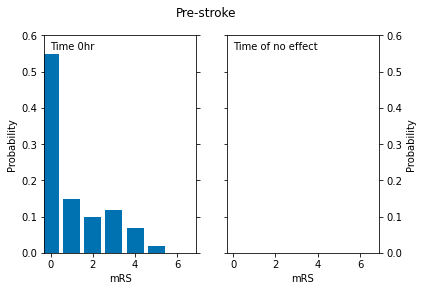

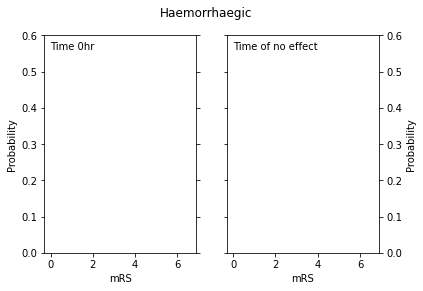

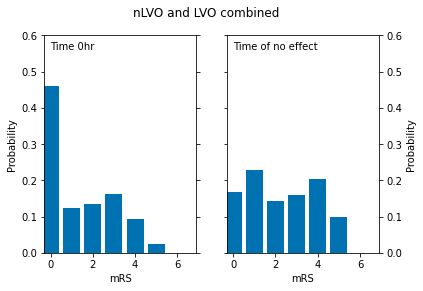

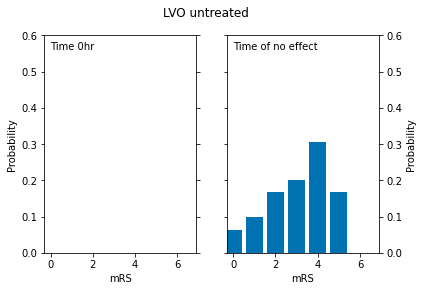

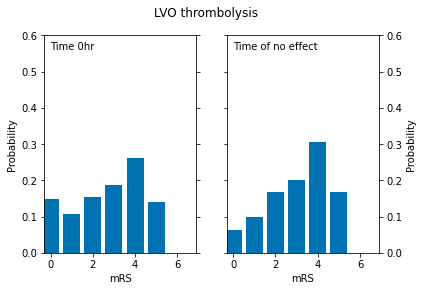

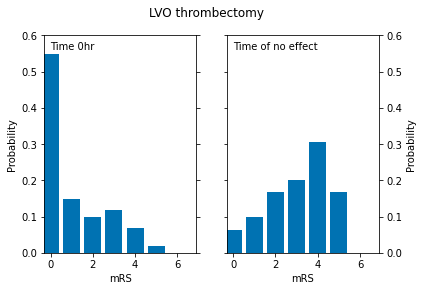

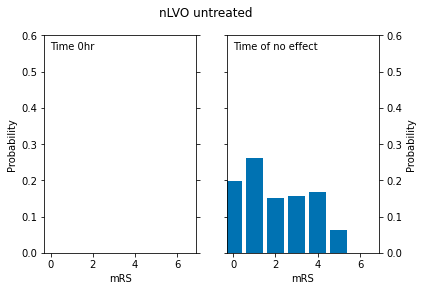

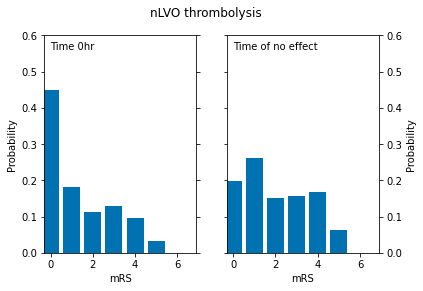

In [14]:
for data_list in big_data_list:
    
    dict_t0  = data_list[0]
    dict_tne = data_list[1]
    label    = data_list[2]
    
    plot_two_bars(dict_t0['dist'], dict_tne['dist'], label)

## Tabulate data

For future reference, here are all of the data printed in comma-separated format. 

In [15]:
# Print the column headings:
print(' '*23 + ',' +' '*11 + ', ' + '-'*30 + 'mRS' + '-'*32)
header = 'Distribution           ,   Time    '
for j in range(6):
    header += ',' + ' '*5 + str(j) + ' '*4 
print(header)
print('-'*102)

# Switch between printing these two times on alternate rows:
times = ['Zero', 'No effect']

# Print each row of data from the big list:
for row in big_data_list:
    for i,data_list in enumerate([row[0], row[1]]):
        # Add label and time to the string:
        p_str = f'{row[2]:23}, {times[i]:10}'
        for j in range(6):
            # Add this mRS value to the string, to 5 decimal places:
            p_str += f',  {data_list["dist"][j]:8.5f}'
        print(p_str)

                       ,           , ------------------------------mRS--------------------------------
Distribution           ,   Time    ,     0    ,     1    ,     2    ,     3    ,     4    ,     5    
------------------------------------------------------------------------------------------------------
Pre-stroke             , Zero      ,   0.54957,   0.14895,   0.09807,   0.11769,   0.06708,   0.01864
Pre-stroke             , No effect ,  -1.00000,  -1.00000,  -1.00000,  -1.00000,  -1.00000,  -1.00000
Haemorrhaegic          , Zero      ,  -1.00000,  -1.00000,  -1.00000,  -1.00000,  -1.00000,  -1.00000
Haemorrhaegic          , No effect ,  -1.00000,  -1.00000,  -1.00000,  -1.00000,  -1.00000,  -1.00000
nLVO and LVO combined  , Zero      ,   0.46101,   0.12495,   0.13468,   0.16163,   0.09212,   0.02561
nLVO and LVO combined  , No effect ,   0.16841,   0.22914,   0.14194,   0.15825,   0.20466,   0.09759
LVO untreated          , Zero      ,  -1.00000,  -1.00000,  -1.00000,  -1.00000,

---

# Distributions that require explanation

## nLVO and LVO combined - t=0

Summary: Use the "no effect" distribution with the t=1hr value from Emberson+2014 to extrapolate back and find a t=0hr point, then scale the pre-stroke bins back to match.

Steps:
1. Gather the known data at different times.
    + Odds ratio $OR(\mathrm{mRS}\leq1, t=1hr)$ from Emberson et al. 2014.
    + Probability $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})$ from Lees et al. 2010.
    + The pre-stroke probability distribution from the SAMueL dataset. 
    
1. Use the function `extrapolate_odds_ratio` to do the following:
   1. Convert $OR(\mathrm{mRS}\leq1, t=1hr)$ and $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})$ to log(odds ratio) and connect the two points with a straight line. 
   1. Extrapolate the line to time zero.
   1. Convert log(odds ratio) at time zero back to probability.
   1. We now have data for $P(\mathrm{mRS}\leq1, t=0)$.
    
1. Use the function `scale_dist` to do the following:
   1. Move the pre-stroke $P(\mathrm{mRS}\leq1)$ value to match $P(\mathrm{mRS}\leq1, t=0)$.
   1. Scale the pre-stroke probabilities for the other mRS bins around $P(\mathrm{mRS}\leq1, t=0)$, otherwise keeping the same bin size proportions.
   
Result: Probability distribution at time zero for the combined nLVO and LVO patients.

__Step 1:__ Use the following imported datasets and known values: 

In [16]:
mrs_prob_bins_no_treatment_nlvo_lvo = dict_no_treatment_nlvo_lvo['bins']
mrs_prob_bins_pre_stroke            = dict_pre_stroke['bins']

In [17]:
OR   = 1.9
t_ne = 6.3 # hours
p_ne = mrs_prob_bins_no_treatment_nlvo_lvo[1]

__Step 2:__ Use the mRS$\leq$1 odds ratio at t=1hr, `OR`, and probability at the no-effect time, `p_ne`, to find the time zero odds ratio `OR_t0` and probability `p_t0`.

(The returned `a` and `b` go unused here but are the constants used to make the straight line log(odds ratio)$=a+bt$.)

In [18]:
from outcome_utilities.extrapolate_odds_ratio import extrapolate_odds_ratio

OR_t0, p_t0, a, b = extrapolate_odds_ratio(
    t_1=60,      OR_1=OR,              # t=1hr data
    t_2=60*t_ne, OR_2=1,   p_2=p_ne,   # t=t_ne data
    t_e=0 )                            # Extrapolate to time 0.

__Step 3:__ Use the new probability `p_t0` to scale the pre-stroke bins:

In [19]:
from outcome_utilities.scale_dist import scale_dist

mrs_prob_dist_t0_treatment_nlvo_lvo, mrs_prob_bins_no_treatment_nlvo_lvo = (
    scale_dist(mrs_prob_bins_pre_stroke, p_t0, mRS_ref=1))

__Result:__ The newly-created time zero probability distribution:

In [20]:
mrs_prob_dist_t0_treatment_nlvo_lvo

array([0.46101   , 0.12494963, 0.1346828 , 0.16163172, 0.09212051,
       0.02560533])

Compare with the imported data:

In [21]:
dict_t0_treatment_nlvo_lvo['dist']

array([0.46101   , 0.12494963, 0.1346828 , 0.16163172, 0.09212051,
       0.02560533])

---

## LVO - thrombolysis only - t=0

Summary: Weighted distribution of 18% full effect (using the time zero pre-stroke distribution) with 82% no effect (using the no-effect-time LVO distribution), as in Holodinsky et al. 2018. 

Steps:
1. Gather the known data.
    + Pre-stroke probability distribution
    + No-effect LVO probability distribution
    + Weights of 18% and 82% respectively.
1. Multiply each distribution by its weighting, and then sum the two weighted distributions.
 
Result: Probability distribution at time zero for the LVO patients treated with thrombolysis.

__Step 1:__ Use the following imported datasets and known values: 

In [22]:
mrs_prob_dist_pre_stroke = dict_pre_stroke['dist']
mrs_prob_dist_no_treatment_lvo = dict_no_treatment_lvo['dist']

In [23]:
from outcome_utilities.mRS_datasets import (
    weight_pre_stroke_lvo_oly, weight_no_treatment_lvo_oly)

print('Weighting for pre-stroke data:',    weight_pre_stroke_lvo_oly)
print('Weighting for untreated LVO data:', weight_no_treatment_lvo_oly)

Weighting for pre-stroke data: 0.18
Weighting for untreated LVO data: 0.82


__Step 2:__ Apply the weights:

In [24]:
mrs_prob_dist_t0_treatment_lvo_oly = (
    (weight_pre_stroke_lvo_oly   * mrs_prob_dist_pre_stroke) + 
    (weight_no_treatment_lvo_oly * mrs_prob_dist_no_treatment_lvo) )

__Result:__ The newly-created time zero probability distribution:

In [25]:
mrs_prob_dist_t0_treatment_lvo_oly

array([0.14947714, 0.10668805, 0.15516151, 0.1870043 , 0.26181487,
       0.13985412])

Compare this with the imported distribution:

In [26]:
dict_t0_treatment_lvo_oly['dist']

array([0.14947714, 0.10668805, 0.15516151, 0.1870043 , 0.26181487,
       0.13985412])

### Plot the weighting

Make the weighted distributions separately:

In [27]:
weighted_pre = weight_pre_stroke_lvo_oly   * mrs_prob_dist_pre_stroke
weighted_lvo = weight_no_treatment_lvo_oly * mrs_prob_dist_no_treatment_lvo

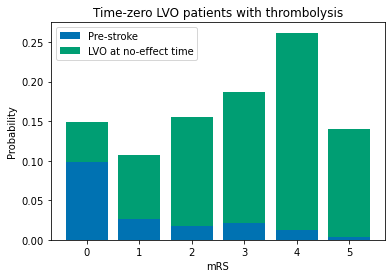

In [28]:
bars = plt.bar(range(6), weighted_pre, label='Pre-stroke' )

# Draw the second set of bars on top of the first using 'tops' list:
tops = bars.datavalues
plt.bar(range(6), weighted_lvo, bottom=tops, label='LVO at no-effect time' )

plt.legend()
plt.xlabel('mRS')
plt.ylabel('Probability')
plt.title('Time-zero LVO patients with thrombolysis')
plt.show()

---

## nLVO - untreated - time of no effect

Summary: Estimate from weighted subtraction of the no-effect LVO data from the no-effect combined nLVO and LVO data, and then scale the resulting distribution using a known data point $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})=0.46$.

Steps:
1. Gather the available data.
    + Probability distribution for no-effect-time combined nLVO and LVO (Lees et al. 2010).
    + Probability distribution for no-effect-time LVO (Goyal et al. 2016).
    + Weights of 100% and -40% respectively. 
    + $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})=0.46$ (Holodinsky et al. 2018).
1. Multiply the distributions by their weights, sum the two, and normalise.
1. Force the calculated $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})$ to equal 46% and scale the other bins around this value using `scale_dist()`.
 
Result: No-effect-time probability distribution for untreated nLVOs.

__Step 1:__ Use the following imported datasets and known values:

In [29]:
mrs_prob_dist_no_treatment_nlvo_lvo = dict_no_treatment_nlvo_lvo['dist']
mrs_prob_dist_no_treatment_lvo      = dict_no_treatment_lvo['dist']

In [30]:
from outcome_utilities.mRS_datasets import (
    weight_no_treatment_nlvo_lvo, weight_no_treatment_lvo)

print('Weights:')
print('untreated nLVO and LVO data:', weight_no_treatment_nlvo_lvo)
print('untreated LVO data:         ', weight_no_treatment_lvo)

Weights:
untreated nLVO and LVO data: 1.0
untreated LVO data:          -0.4


__Step 2:__ Apply the weights:

In [31]:
mrs_prob_dist_no_treatment_nlvo = (
    (weight_no_treatment_nlvo_lvo * mrs_prob_dist_no_treatment_nlvo_lvo) + 
    (weight_no_treatment_lvo      * mrs_prob_dist_no_treatment_lvo) )

Currently the bins are unlikely to sum to 1 as required, so they must be normalised:

In [32]:
mrs_prob_dist_no_treatment_nlvo = (
    mrs_prob_dist_no_treatment_nlvo / np.sum(mrs_prob_dist_no_treatment_nlvo))

In [33]:
mrs_prob_dist_no_treatment_nlvo

array([0.23958184, 0.31696477, 0.12476506, 0.12894086, 0.13806616,
       0.05168132])

__Step 3:__ Compare the current $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})$ with the expected 46%.

In [34]:
mrs_prob_bins_no_treatment_nlvo = np.cumsum(mrs_prob_dist_no_treatment_nlvo)

In [35]:
mrs_prob_bins_no_treatment_nlvo[1]

0.5565466025542539

Because the values don't match, we'll force $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})$ to equal 46% and scale the other bins around this movement so that they keep the same proportions.  

In [36]:
mRS_ref_nlvo = 1
p_ref_nlvo   = 0.46

In [37]:
from outcome_utilities.scale_dist import scale_dist

mrs_prob_dist_no_treatment_nlvo, mrs_prob_bins_no_treatment_nlvo = (
    scale_dist(mrs_prob_bins_no_treatment_nlvo, p_ref_nlvo, 
               mRS_ref=mRS_ref_nlvo))

__Result:__ The newly-created probability distribution:

In [38]:
mrs_prob_dist_no_treatment_nlvo

array([0.19802051, 0.26197949, 0.15192832, 0.15701327, 0.16812528,
       0.06293313])

The mRS$\leq$1 bin is 0.46 as required:

In [39]:
mrs_prob_bins_no_treatment_nlvo

array([0.19802051, 0.46      , 0.61192832, 0.76894159, 0.93706687,
       1.        ])

Compare with the imported data:

In [40]:
dict_no_treatment_nlvo['dist']

array([0.19802051, 0.26197949, 0.15192832, 0.15701327, 0.16812528,
       0.06293313])

---

## nLVO - thrombolysis

## t=0 distribution

Summary: Weighted distribution of the pre-stroke and no-effect-time nLVO distributions. The weights are chosen to give $P(\mathrm{mRS}<=1, t=0)=$63%.

Steps:
1. Gather the known data.
    + Probability distribution for pre-stroke patients (SAMueL-1).
    + Probability distribution for nLVO patients treated with thrombolysis at the no-effect-time ([calculated here](#nLVO---untreated---time-of-no-effect)).
    + $P(\mathrm{mRS}<=1, t=0)=$63% (Holodinsky et al. 2018).
1. Calculate the weights needed to combine the two probability distributions and ensure that $P(\mathrm{mRS}<=1, t=0)=$63%.
1. Multiply the distributions by the weights and sum them. 

Result: A probability distribution for nLVO patients treated with thrombolysis at time zero.
 

__Step 1:__ Use the following imported datasets and known values:

In [41]:
mrs_prob_bins_no_treatment_nlvo_oly = dict_no_treatment_nlvo_oly['bins']
mrs_prob_dist_no_treatment_nlvo_oly = dict_no_treatment_nlvo_oly['dist']

mrs_prob_bins_pre_stroke = dict_pre_stroke['bins']
mrs_prob_dist_pre_stroke = dict_pre_stroke['dist']

__Step 2:__ Calculate the weights needed to give a distribution with $P(\mathrm{mRS}<=1, t=0)=$63%:

In [42]:
target_diff  = 0.63 - mrs_prob_bins_no_treatment_nlvo_oly[1]
current_diff = (mrs_prob_bins_pre_stroke[1] - 
                mrs_prob_bins_no_treatment_nlvo_oly[1])

weight_pre_stroke_nlvo_oly   = target_diff / current_diff
weight_no_treatment_nlvo_oly = 1.0 - weight_pre_stroke_nlvo_oly

print('Weights: ', weight_pre_stroke_nlvo_oly, weight_no_treatment_nlvo_oly)

Weights:  0.7127280650232234 0.2872719349767766


Compare these weights with the values used to create the imported data:

In [43]:
from outcome_utilities.mRS_datasets import (weight_pre_stroke_nlvo_oly, 
                                            weight_no_treatment_nlvo_oly)

print(weight_pre_stroke_nlvo_oly, weight_no_treatment_nlvo_oly)

0.7127280650232234 0.2872719349767766


__Step 3:__ Apply the weights:

In [44]:
mrs_prob_dist_t0_treatment_nlvo_oly = (
    (weight_pre_stroke_nlvo_oly   * mrs_prob_dist_pre_stroke) + 
    (weight_no_treatment_nlvo_oly * mrs_prob_dist_no_treatment_nlvo_oly) )


mrs_prob_bins_t0_treatment_nlvo_oly = np.cumsum(
    mrs_prob_dist_t0_treatment_nlvo_oly)

__Result:__ The newly-created probability distribution:

In [45]:
mrs_prob_dist_t0_treatment_nlvo_oly

array([0.44857841, 0.18142159, 0.11354063, 0.12898698, 0.09610515,
       0.03136724])

Now $P(\mathrm{mRS}<=1, t=0)=$63% as required:

In [46]:
mrs_prob_bins_t0_treatment_nlvo_oly

array([0.44857841, 0.63      , 0.74354063, 0.87252761, 0.96863276,
       1.        ])

Compare with the imported data:

In [47]:
dict_t0_treatment_nlvo_oly['dist']

array([0.44857841, 0.18142159, 0.11354063, 0.12898698, 0.09610515,
       0.03136724])

### Plot the weighting

Make the weighted distributions separately:

In [48]:
weighted_pre      = (weight_pre_stroke_nlvo_oly   * 
                     mrs_prob_dist_pre_stroke )
weighted_nlvo_oly = (weight_no_treatment_nlvo_oly * 
                     mrs_prob_dist_no_treatment_nlvo_oly )

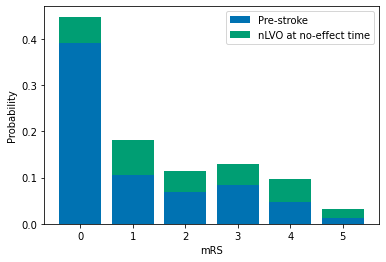

In [49]:
bars = plt.bar(range(6), weighted_pre, label='Pre-stroke' )

# Draw the second set of bars on top of the first using 'tops' list:
tops = bars.datavalues
plt.bar(range(6), weighted_nlvo_oly, bottom=tops, 
        label='nLVO at no-effect time' )

plt.legend()
plt.xlabel('mRS')
plt.ylabel('Probability')
plt.show()

---

## References

Emberson J, Lees KR, Lyden P, et al. _Effect of treatment delay, age, and stroke severity on the effects of intravenous thrombolysis with alteplase for acute ischaemic stroke: A meta-analysis of individual patient data from randomised trials._ The Lancet 2014;384:1929–35. doi:10.1016/S0140-6736(14)60584-5

Goyal M, Menon BK, van Zwam WH, et al. _Endovascular thrombectomy after large-vessel ischaemic stroke: a meta-analysis of individual patient data from five randomised trials._ The Lancet 2016;387:1723-1731. doi:10.1016/S0140-6736(16)00163-X

Holodinsky JK, Williamson TS, Demchuk AM, et al. _Modeling Stroke Patient Transport for All Patients With Suspected Large-Vessel Occlusion._ JAMA Neurol. 2018;75(12):1477-1486. doi:10.1001/jamaneurol.2018.2424

Lees KR, Bluhmki E, von Kummer R, et al. _Time to treatment with intravenous alteplase and outcome in stroke: an updated pooled analysis of ECASS, ATLANTIS, NINDS, and EPITHET trials_. The Lancet 2010;375:1695-703. doi:10.1016/S0140-6736(10)60491-6

SAMueL-1 data